In [1]:
!cp -r ../input/pytorch-segmentation-models-lib/ ./
# !cp -r ../input/timm-pytorch-image-models/pytorch-image-models-master ./

In [2]:
# !pip install -q ./timm-pytorch-image-models/pytorch-image-models-master

In [3]:
!pip config set global.disable-pip-version-check true

Writing to /root/.config/pip/pip.conf


In [4]:
!pip install -q ./pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q ./pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
!pip install -q ./pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
!pip install -q ./pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [5]:
!mkdir -p /root/.cache/torch/hub/checkpoints/

!cp ../input/efficientnet-pytorch-b0-b7/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
!cp ../input/efficientnet-pytorch-b0-b7/efficientnet-b7-dcc49843.pth /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth

In [6]:
import numpy as np
import pandas as pd

# vizualizations
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torch.nn.functional as F

# folds
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tqdm import tqdm
import gc
import random
import os

import segmentation_models_pytorch as smp

In [7]:
def visualize(figsize=(30, 30), **images):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title().lower())
        plt.imshow(image)
    plt.show()
    
    
def plot_tiled_image(image, fig_size=[10, 10]):
    fig = plt.figure(figsize=fig_size)
    rows = int(np.sqrt(image.shape[0]))
    columns = rows

    for i in range(1, columns*rows+1):
        img = image[i-1, 0, ...]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

In [8]:
# ref: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape) == 3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)

#ref: https://www.kaggle.com/code/bguberfain/memory-aware-rle-encoding/notebook
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    This simplified method requires first and last pixel to be zero
    '''
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [9]:
def nearest(n, x):
    u = n % x > x // 2
    r = n + (-1) ** (1 - u) * abs(x * u - n % x)
    
#     if r % n == 0:
#         return r
    return r + x

In [10]:
normalize_0_255 = lambda x: (x * 255) / x.max()

def normalize_mean_std(a, axis=None): 
    mean = np.mean(a, axis=axis, keepdims=True)
    std = np.std(a, axis=axis, keepdims=True)
    return (a - mean) / std

def normalize_max(a):
    return a / a.max()

def normalize_255_mean_std(a):
    mean = np.array([0.7720342, 0.74582646, 0.76392896])
    std = np.array([0.24745085, 0.26182273, 0.25782376])
    return (a / 255.0 - mean) / std

def normalize_255_mean_std_v2(a):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (a / 255. - mean) / std

In [11]:
class cfg:
    dataset_path        = '../input/hubmap-organ-segmentation'
    
    train_images        = f'{dataset_path}/train_images'
    train_annotations   = f'{dataset_path}/train_annotations'
    test_images         = f'{dataset_path}/test_images'
    
    train_csv           = f'{dataset_path}/train.csv'
    test_csv            = f'{dataset_path}/test.csv'
    submission_csv      = f'{dataset_path}/sample_submission.csv'
    
    name        = '[all] - 736 + [lung-t1] - 1024'
    seed        = 3407
    n_folds     = 3
    
    tiles       = False
    img_size    = [736, 736]
    tile_size   = 512
    stride      = (nearest(img_size[0], tile_size) - img_size[0]) // 4

    backbone    = 'convnext_base_22k_224'
    num_classes = 1
    tta         = True
    
    organ_mean_thresh_f = {
        'HPA': {
            'kidney': 1.75,
            'largeintestine': 1.75,
            'lung': 1.75,
            'prostate': 1.75,
            'spleen': 1.75,          # not much change from 2.5 -> 1.5 (stable preds)
        },
        'Hubmap': {
            'kidney': 1.75,
            'largeintestine': 1.75,
            'lung': 1.75,
            'prostate': 1.75,
            'spleen': 1.75,          
        },
    }
    
    device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
print(cfg.img_size)
print(cfg.tile_size)
print(cfg.stride)

[736, 736]
512
72


In [13]:
# 0.78
# - lung: 0.10 LB
# MODELS = {
#     'fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v0/GUME/GUME-convnext_upernet-768-rgb-norm255_mean_std_v2-augheavy_-fold00-dice0.7249.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     'fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v0/GUME/GUME-convnext_upernet-768-rgb-norm255_mean_std_v2-augheavy_-fold01-dice0.8332.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     'fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v0/GUME/GUME-convnext_upernet-768-rgb-norm255_mean_std_v2-augheavy_-fold02-dice0.7435.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     'fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v0/GUME/GUME-convnext_upernet-768-rgb-norm255_mean_std_v2-augheavy_-fold03-dice0.7618.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     'fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v0/GUME/GUME-convnext_upernet-768-rgb-norm255_mean_std_v2-augheavy_-fold04-dice0.7421.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
# }


MODELS = {
    '[GUME]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v0/GUME/GUME-convnext_upernet-768-rgb-norm255_mean_std_v2-augheavy_-fold00-dice0.7249.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[GUME]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v0/GUME/GUME-convnext_upernet-768-rgb-norm255_mean_std_v2-augheavy_-fold01-dice0.8332.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[GUME]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v0/GUME/GUME-convnext_upernet-768-rgb-norm255_mean_std_v2-augheavy_-fold02-dice0.7435.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[GUME]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v0/GUME/GUME-convnext_upernet-768-rgb-norm255_mean_std_v2-augheavy_-fold03-dice0.7618.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[GUME]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v0/GUME/GUME-convnext_upernet-768-rgb-norm255_mean_std_v2-augheavy_-fold04-dice0.7421.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    
    
    
    '[COOP]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/COOP/COOP-convnext_upernet_b-768-norm255_mean_std_v2-augheavy5cd-all-fold00-dice0.7423.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[COOP]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/COOP/COOP-convnext_upernet_b-768-norm255_mean_std_v2-augheavy5cd-all-fold01-dice0.8414.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[COOP]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/COOP/COOP-convnext_upernet_b-768-norm255_mean_std_v2-augheavy5cd-all-fold02-dice0.7587.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[COOP]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/COOP/COOP-convnext_upernet_b-768-norm255_mean_std_v2-augheavy5cd-all-fold03-dice0.7671.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[COOP]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/COOP/COOP-convnext_upernet_b-768-norm255_mean_std_v2-augheavy5cd-all-fold04-dice0.7624.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    
    
    
    '[JODO]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/JODO/JODO-convnext_upernet_b-768-norm255_mean_std_v2-augheavy4-all-fold00-dice0.7435.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[JODO]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/JODO/JODO-convnext_upernet_b-768-norm255_mean_std_v2-augheavy4-all-fold01-dice0.8396.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[JODO]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/JODO/JODO-convnext_upernet_b-768-norm255_mean_std_v2-augheavy4-all-fold02-dice0.7602.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[JODO]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/JODO/JODO-convnext_upernet_b-768-norm255_mean_std_v2-augheavy4-all-fold03-dice0.7639.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[JODO]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/JODO/JODO-convnext_upernet_b-768-norm255_mean_std_v2-augheavy4-all-fold04-dice0.7616.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    
    
    
#     '[NEXT]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v1/NEXT/NEXT-convnext_upernet_b-768-norm255_mean_std_v2-augheavy4-all-lung_g1_f-fold00-dice0.7836.pth',
#         'num_classes': 1,
#         'arch': 'convnext_upernet',
#         'weight': 1
#     },
#     '[NEXT]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v1/NEXT/NEXT-convnext_upernet_b-768-norm255_mean_std_v2-augheavy4-all-lung_g1_f-fold01-dice0.8791.pth',
#         'num_classes': 1,
#         'arch': 'convnext_upernet',
#         'weight': 1
#     },
#     '[NEXT]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v1/NEXT/NEXT-convnext_upernet_b-768-norm255_mean_std_v2-augheavy4-all-lung_g1_f-fold02-dice0.7557.pth',
#         'num_classes': 1,
#         'arch': 'convnext_upernet',
#         'weight': 1
#     },
    '[NEXT]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v1/NEXT/NEXT-convnext_upernet_b-768-norm255_mean_std_v2-augheavy4-all-lung_g1_f-fold03-dice0.7937.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
#     '[NEXT]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v1/NEXT/NEXT-convnext_upernet_b-768-norm255_mean_std_v2-augheavy4-all-lung_g1_f-fold04-dice0.8005.pth',
#         'num_classes': 1,
#         'arch': 'convnext_upernet',
#         'weight': 1
#     },
    
    
#     '[A005]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v2/A005/A005-hornet_upernet-b-768-norm255_mean_std_v2-augheavy4cds-all-fold00-dice0.7330.pth',
#         'num_classes': 1,
#         'arch': 'hornet_upernet',
#         'weight': 1
#     },
#     '[A005]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v2/A005/A005-hornet_upernet-b-768-norm255_mean_std_v2-augheavy4cds-all-fold01-dice0.8489.pth',
#         'num_classes': 1,
#         'arch': 'hornet_upernet',
#         'weight': 1
#     },
#     '[A005]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v2/A005/A005-hornet_upernet-b-768-norm255_mean_std_v2-augheavy4cds-all-fold02-dice0.7685.pth',
#         'num_classes': 1,
#         'arch': 'hornet_upernet',
#         'weight': 1
#     },
#     '[A005]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v2/A005/A005-hornet_upernet-b-768-norm255_mean_std_v2-augheavy4cds-all-fold03-dice0.7695.pth',
#         'num_classes': 1,
#         'arch': 'hornet_upernet',
#         'weight': 1
#     },
#     '[A005]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-models-v2/A005/A005-hornet_upernet-b-768-norm255_mean_std_v2-augheavy4cds-all-fold04-dice0.7611.pth',
#         'num_classes': 1,
#         'arch': 'hornet_upernet',
#         'weight': 1
#     },
    
    
    
    '[A007]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v2/A007/A007-hornet_upernet-b-gf-768-norm255_mean_std_v2-augheavy4cds--all-fold00-dice0.7455.pth',
        'num_classes': 1,
        'arch': 'hornet_upernet',
        'weight': 1
    },
    '[A007]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v2/A007/A007-hornet_upernet-b-gf-768-norm255_mean_std_v2-augheavy4cds--all-fold01-dice0.8459.pth',
        'num_classes': 1,
        'arch': 'hornet_upernet',
        'weight': 1
    },
    '[A007]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v2/A007/A007-hornet_upernet-b-gf-768-norm255_mean_std_v2-augheavy4cds--all-fold02-dice0.7745.pth',
        'num_classes': 1,
        'arch': 'hornet_upernet',
        'weight': 1
    },
    '[A007]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v2/A007/A007-hornet_upernet-b-gf-768-norm255_mean_std_v2-augheavy4cds--all-fold03-dice0.7688.pth',
        'num_classes': 1,
        'arch': 'hornet_upernet',
        'weight': 1
    },
    '[A007]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v2/A007/A007-hornet_upernet-b-gf-768-norm255_mean_std_v2-augheavy4cds--all-fold04-dice0.7570.pth',
        'num_classes': 1,
        'arch': 'hornet_upernet',
        'weight': 1
    },
    
    
    '[A008]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v2/A008/A008-hornet_upernet-b-gf-768-norm255_mean_std_v2-augheavy4cds--all-xlung-fold00-dice0.8651.pth',
        'num_classes': 1,
        'arch': 'hornet_upernet',
        'weight': 1
    },
    '[A008]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v2/A008/A008-hornet_upernet-b-gf-768-norm255_mean_std_v2-augheavy4cds--all-xlung-fold01-dice0.9110.pth',
        'num_classes': 1,
        'arch': 'hornet_upernet',
        'weight': 1
    },
    '[A008]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v2/A008/A008-hornet_upernet-b-gf-768-norm255_mean_std_v2-augheavy4cds--all-xlung-fold02-dice0.8628.pth',
        'num_classes': 1,
        'arch': 'hornet_upernet',
        'weight': 1
    },
    '[A008]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v2/A008/A008-hornet_upernet-b-gf-768-norm255_mean_std_v2-augheavy4cds--all-xlung-fold03-dice0.8517.pth',
        'num_classes': 1,
        'arch': 'hornet_upernet',
        'weight': 1
    },
    '[A008]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-models-v2/A008/A008-hornet_upernet-b-gf-768-norm255_mean_std_v2-augheavy4cds--all-xlung-fold04-dice0.8785.pth',
        'num_classes': 1,
        'arch': 'hornet_upernet',
        'weight': 1
    },
}

In [14]:
# LUNG_MODELS = {
#     '[lung_g1_f]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/MOTO/MOTO-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy4-lung-g1-f-fold00-dice0.2923.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_g1_f]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/MOTO/MOTO-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy4-lung-g1-f-fold01-dice0.5040.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_g1_f]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/MOTO/MOTO-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy4-lung-g1-f-fold02-dice0.3659.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_g1_f]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/MOTO/MOTO-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy4-lung-g1-f-fold03-dice0.4879.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_g1_f]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/MOTO/MOTO-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy4-lung-g1-f-fold04-dice0.3770.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
# }

# LUNG_MODELS = {
#     '[lung_t1]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/GIGA/GIGA-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy-fold00-dice0.3542.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_t1]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/GIGA/GIGA-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy-fold01-dice0.3732.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_t1]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/GIGA/GIGA-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy-fold02-dice0.4176.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_t1]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/GIGA/GIGA-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy-fold03-dice0.5012.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_t1]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/GIGA/GIGA-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy-fold04-dice0.4236.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
# }


LUNG_MODELS = {
    '[lung_g1_f]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-lung-models-v1/GIGA/GIGA-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy-fold00-dice0.3542.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[lung_g1_f]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-lung-models-v1/MOTO/MOTO-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy4-lung-g1-f-fold01-dice0.5040.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 2
    },
    '[lung_g1_f]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-lung-models-v1/GIGA/GIGA-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy-fold02-dice0.4176.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
    '[lung_g1_f]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-lung-models-v1/GIGA/GIGA-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy-fold03-dice0.5012.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 2
    },
    '[lung_g1_f]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
        'backbone': None,
        'weights': '../input/hubmap-hpa-lung-models-v1/GIGA/GIGA-convnext_upernet-1024x512x2-norm255_mean_std_v2-augheavy-fold04-dice0.4236.pth',
        'num_classes': 1,
        'arch': 'convnext_upernet',
        'weight': 1
    },
}


# LUNG_MODELS = {
#     '[lung_g1_f]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/XEOI/XEOI-convnext_upernet-1024-norm255_mean_std_v2-augheavy5cd-lung_g1-fold00-dice0.2870.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_g1_f]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/XEOI/XEOI-convnext_upernet-1024-norm255_mean_std_v2-augheavy5cd-lung_g1-fold01-dice0.3065.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_g1_f]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/XEOI/XEOI-convnext_upernet-1024-norm255_mean_std_v2-augheavy5cd-lung_g1-fold02-dice0.4827.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_g1_f]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/XEOI/XEOI-convnext_upernet-1024-norm255_mean_std_v2-augheavy5cd-lung_g1-fold03-dice0.5141.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
#     '[lung_g1_f]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++': {
#         'backbone': None,
#         'weights': '../input/hubmap-hpa-lung-models-v1/XEOI/XEOI-convnext_upernet-1024-norm255_mean_std_v2-augheavy5cd-lung_g1-fold04-dice0.3544.pth',
#         'num_classes': 1,
#         'weight': 1
#     },
# }

In [15]:
def set_seed(seed=42):
    '''
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY
    '''
    print(f'- SETTING SEED: {seed}')

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('- SEEDING DONE')
    
set_seed(cfg.seed)

- SETTING SEED: 3407
- SEEDING DONE


In [16]:
def conv3x3_bn_relu(in_planes, out_planes, stride=1):
	"3x3 convolution + BN + relu"
	return nn.Sequential(
		nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False),
		nn.BatchNorm2d(out_planes),
		nn.ReLU(inplace=True),
	)

 
# upernet
class UPerDecoder(nn.Module):
	def __init__(self,
	    in_dim=[256, 512, 1024, 2048],
	    ppm_pool_scale=[1, 2, 3, 6],
	    ppm_dim=512,
	    fpn_out_dim=256
	):
		super(UPerDecoder, self).__init__()

		# PPM ----
		dim         = in_dim[-1]
		ppm_pooling = []
		ppm_conv    = []
		
		for scale in ppm_pool_scale:
			ppm_pooling.append(
				nn.AdaptiveAvgPool2d(scale)
			)
			ppm_conv.append(
				nn.Sequential(
					nn.Conv2d(dim, ppm_dim, kernel_size=1, bias=False),
					nn.BatchNorm2d(ppm_dim),
					nn.ReLU(inplace=True)
				)
			)
		self.ppm_pooling    = nn.ModuleList(ppm_pooling)
		self.ppm_conv       = nn.ModuleList(ppm_conv)
		self.ppm_out        = conv3x3_bn_relu(dim + len(ppm_pool_scale)*ppm_dim, fpn_out_dim, 1)
		
		# FPN ----
		fpn_in = []
		for i in range(0, len(in_dim)-1):  # skip the top layer
			fpn_in.append(
				nn.Sequential(
					nn.Conv2d(in_dim[i], fpn_out_dim, kernel_size=1, bias=False),
					nn.BatchNorm2d(fpn_out_dim),
					nn.ReLU(inplace=True)
				)
			)
		self.fpn_in = nn.ModuleList(fpn_in)
		
		fpn_out = []
		for i in range(len(in_dim) - 1):  # skip the top layer
			fpn_out.append(
				conv3x3_bn_relu(fpn_out_dim, fpn_out_dim, 1),
			)
		self.fpn_out = nn.ModuleList(fpn_out)
		self.fpn_fuse = nn.Sequential(
			conv3x3_bn_relu(len(in_dim) * fpn_out_dim, fpn_out_dim, 1),
		)
	
	def forward(self, feature):
		f = feature[-1]
		pool_shape = f.shape[2:]
		
		ppm_out = [f]
		for pool, conv in zip(self.ppm_pooling, self.ppm_conv):
			p = pool(f)
			p = F.interpolate(p, size=pool_shape, mode='bilinear', align_corners=False)
			p = conv(p)
			ppm_out.append(p)
		ppm_out = torch.cat(ppm_out, 1)
		down = self.ppm_out(ppm_out)
		
		
		#--------------------------------------
		fpn_out = [down]
		for i in reversed(range(len(feature) - 1)):
			lateral = feature[i]
			lateral = self.fpn_in[i](lateral) # lateral branch
			down = F.interpolate(down, size=lateral.shape[2:], mode='bilinear', align_corners=False) # top-down branch
			down = down + lateral
			fpn_out.append(self.fpn_out[i](down))
		
		fpn_out.reverse() # [P2 - P5]
		fusion_shape = fpn_out[0].shape[2:]
		fusion = [fpn_out[0]]
		for i in range(1, len(fpn_out)):
			fusion.append(
				F.interpolate( fpn_out[i], fusion_shape, mode='bilinear', align_corners=False)
			)
		x = self.fpn_fuse( torch.cat(fusion, 1))
		
		return x, fusion

In [17]:
import torch
from torch import nn, Tensor
from torchvision.ops import StochasticDepth


class LayerNorm(nn.Module):
    """Channel first layer norm
    """
    def __init__(self, normalized_shape, eps=1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps

    def forward(self, x: Tensor) -> Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x

    
class Block(nn.Module):
    def __init__(self, dim, dpr=0., init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, 7, 1, 3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4*dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4*dim, dim)
        self.gamma = nn.Parameter(init_value * torch.ones((dim)), requires_grad=True) if init_value > 0 else None
        self.drop_path = StochasticDepth(dpr, mode="batch") if dpr > 0. else nn.Identity()

    def forward(self, x: Tensor) -> Tensor:
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)   # NCHW to NHWC
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma * x
        
        x = x.permute(0, 3, 1, 2)
        x = input + self.drop_path(x)
        return x


class Stem(nn.Sequential):
    def __init__(self, c1, c2, k, s):
        super().__init__(
            nn.Conv2d(c1, c2, k, s),
            LayerNorm(c2)
        )


class Downsample(nn.Sequential):
    def __init__(self, c1, c2, k, s):
        super().__init__(
            LayerNorm(c1),
            nn.Conv2d(c1, c2, k, s)
        )


convnext_settings = {
    'T': [[3, 3, 9, 3], [96, 192, 384, 768], 0.0],       # [depths, dims, dpr]
    'S': [[3, 3, 27, 3], [96, 192, 384, 768], 0.0],
    'B': [[3, 3, 27, 3], [128, 256, 512, 1024], 0.0]
}


class ConvNeXt(nn.Module):     
    def __init__(self, model_name: str = 'T') -> None:
        super().__init__()
        assert model_name in convnext_settings.keys(), f"ConvNeXt model name should be in {list(convnext_settings.keys())}"
        depths, embed_dims, drop_path_rate = convnext_settings[model_name]
        self.channels = embed_dims
    
        self.downsample_layers = nn.ModuleList([
            Stem(3, embed_dims[0], 4, 4),
            *[Downsample(embed_dims[i], embed_dims[i+1], 2, 2) for i in range(3)]
        ])

        self.stages = nn.ModuleList()
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0

        for i in range(4):
            stage = nn.Sequential(*[
                Block(embed_dims[i], dpr[cur+j])
            for j in range(depths[i])])
            self.stages.append(stage)
            cur += depths[i]

        for i in range(4):
            self.add_module(f"norm{i}", LayerNorm(embed_dims[i]))

    def forward(self, x: Tensor):
        outs = []

        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
            norm_layer = getattr(self, f"norm{i}")
            outs.append(norm_layer(x))
        return outs


if __name__ == '__main__':
    model = ConvNeXt('B')

    x = torch.randn(1, 3, 224, 224)
    feats = model(x)
    for y in feats:
        print(y.shape)

torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 1024, 7, 7])


In [18]:
class MixUpScaler(nn.Module):
    def __init__(self, scale_factor=2):
        super().__init__()
        self.mixing = nn.Parameter(torch.tensor(0.5))
        self.scale_factor = scale_factor

    def forward(self, x):
        x = self.mixing * F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear', align_corners=False) \
            + (1 - self.mixing) * F.interpolate(x, scale_factor=self.scale_factor, mode='bicubic')
        return x



class ConvNextUperNet(nn.Module):
    def load_pretrain(self):
        checkpoint = '/content/convnext_base_22k_224.pth'

        self.arch = 'convnext_large_22k_224'

        print(f'loading [{checkpoint}]...')
        checkpoint = torch.load(checkpoint, map_location=lambda storage, loc: storage)['model']
        self.encoder.load_state_dict(checkpoint, strict=False)  # True
        print(f'weights for [{self.arch}] loaded successfully!')


    def __init__(self):
        super(ConvNextUperNet, self).__init__()
        # mixup scaling [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7924688/]
        self.scale = MixUpScaler(scale_factor=4)  

        # swin encoder
        self.encoder = ConvNeXt('B')
        encoder_dim = [128, 256, 512, 1024]
        
        # upernet decoder
        self.decoder = UPerDecoder(
            in_dim=encoder_dim,
            ppm_pool_scale=[1, 2, 3, 6],
            ppm_dim=512,
            fpn_out_dim=256
        )
        
        self.logit = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=1)
        )
        self.aux = nn.ModuleList([
            nn.Conv2d(256, 1, kernel_size=1, padding=0) for i in range(4)
        ])

    def forward(self, x):
        B, C, H, W = x.shape

        # encoder branch
        x = self.encoder(x)
        
        # decoder branch
        x, _ = self.decoder(x)
        
        # out
        logit = self.logit(x)
        x = self.scale(logit)
            
        return x

    
convnext_upernet = ConvNextUperNet()
    
if __name__ == '__main__':
    model = ConvNextUperNet()

    x = torch.randn(1, 3, 616, 616)
    
    out = model(x)
    print(out.shape)

torch.Size([1, 1, 616, 616])


In [19]:
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
import os
import sys
import torch.fft
import traceback

import torch.utils.checkpoint as checkpoint


# if 'DWCONV_IMPL' in os.environ:
#     try:
#         sys.path.append(os.environ['DWCONV_IMPL'])
#         from depthwise_conv2d_implicit_gemm import DepthWiseConv2dImplicitGEMM
#
#
        # def get_dwconv(dim, kernel, bias):
        #     return DepthWiseConv2dImplicitGEMM(dim, kernel, bias)
#         # print('Using Megvii large kernel dw conv impl')
#     except:
#         print(traceback.format_exc())
#
#
def get_dwconv(dim, kernel, bias):
    return nn.Conv2d(dim, dim, kernel_size=kernel, padding=(kernel - 1) // 2, bias=bias, groups=dim)


#
#         # print('[fail to use Megvii Large kernel] Using PyTorch large kernel dw conv impl')
# else:
#     def get_dwconv(dim, kernel, bias):
#         return nn.Conv2d(dim, dim, kernel_size=kernel, padding=(kernel - 1) // 2, bias=bias, groups=dim)
#
#     # print('Using PyTorch large kernel dw conv impl')


class GlobalLocalFilter(nn.Module):
    def __init__(self, dim, h=14, w=8):
        super().__init__()
        self.dw = nn.Conv2d(dim // 2, dim // 2, kernel_size=3, padding=1, bias=False, groups=dim // 2)
        self.complex_weight = nn.Parameter(torch.randn(dim // 2, h, w, 2, dtype=torch.float32) * 0.02)
        trunc_normal_(self.complex_weight, std=.02)
        self.pre_norm = LayerNorm(dim, eps=1e-6, data_format='channels_first')
        self.post_norm = LayerNorm(dim, eps=1e-6, data_format='channels_first')

    def forward(self, x):
        x = self.pre_norm(x)
        x1, x2 = torch.chunk(x, 2, dim=1)
        x1 = self.dw(x1)

        x2 = x2.to(torch.float32)
        B, C, a, b = x2.shape
        x2 = torch.fft.rfft2(x2, dim=(2, 3), norm='ortho')

        weight = self.complex_weight
        if not weight.shape[1:3] == x2.shape[2:4]:
            weight = F.interpolate(weight.permute(3, 0, 1, 2), size=x2.shape[2:4], mode='bilinear',
                                   align_corners=True).permute(1, 2, 3, 0)

        weight = torch.view_as_complex(weight.contiguous())

        x2 = x2 * weight
        x2 = torch.fft.irfft2(x2, s=(a, b), dim=(2, 3), norm='ortho')

        x = torch.cat([x1.unsqueeze(2), x2.unsqueeze(2)], dim=2).reshape(B, 2 * C, a, b)
        x = self.post_norm(x)
        return x


class gnconv(nn.Module):
    def __init__(self, dim, order=5, gflayer=None, h=14, w=8, s=1.0):
        super().__init__()
        self.order = order
        self.dims = [dim // 2 ** i for i in range(order)]
        self.dims.reverse()
        self.proj_in = nn.Conv2d(dim, 2 * dim, 1)

        if gflayer is None:
            self.dwconv = get_dwconv(sum(self.dims), 7, True)
        else:
            self.dwconv = gflayer(sum(self.dims), h=h, w=w)

        self.proj_out = nn.Conv2d(dim, dim, 1)

        self.pws = nn.ModuleList(
            [nn.Conv2d(self.dims[i], self.dims[i + 1], 1) for i in range(order - 1)]
        )

        self.scale = s

        # print('[gconv]', order, 'order with dims=', self.dims, 'scale=%.4f' % self.scale)

    def forward(self, x, mask=None, dummy=False):
        B, C, H, W = x.shape

        fused_x = self.proj_in(x)
        pwa, abc = torch.split(fused_x, (self.dims[0], sum(self.dims)), dim=1)

        dw_abc = self.dwconv(abc) * self.scale

        dw_list = torch.split(dw_abc, self.dims, dim=1)
        x = pwa * dw_list[0]

        for i in range(self.order - 1):
            x = self.pws[i](x) * dw_list[i + 1]

        x = self.proj_out(x)

        return x


class Block(nn.Module):
    r""" HorNet block
    """

    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6, gnconv=gnconv):
        super().__init__()

        self.norm1 = LayerNorm(dim, eps=1e-6, data_format='channels_first')
        self.gnconv = gnconv(dim)  # depthwise conv
        self.norm2 = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)

        self.gamma1 = nn.Parameter(layer_scale_init_value * torch.ones(dim),
                                   requires_grad=True) if layer_scale_init_value > 0 else None

        self.gamma2 = nn.Parameter(layer_scale_init_value * torch.ones((dim)),
                                   requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        if self.gamma1 is not None:
            gamma1 = self.gamma1.view(C, 1, 1)
        else:
            gamma1 = 1
        x = x + self.drop_path(gamma1 * self.gnconv(self.norm1(x)))

        input = x
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.norm2(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma2 is not None:
            x = self.gamma2 * x
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x


class HorNet(nn.Module):
    r""" HorNet
        A PyTorch impl of : `HorNet: Efficient High-Order Spatial Interactions with Recursive Gated Convolutions`
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """

    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[2, 3, 18, 2], base_dim=128, drop_path_rate=0.4,
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 gnconv=gnconv, block=Block, out_indices=[0, 1, 2, 3],
                 pretrained=None,
                 use_checkpoint=False,
                 ):
        super().__init__()
        depths = [2, 3, 18, 2]
        base_dim = 128
#         gnconv = [
#                      'partial(gnconv, order=2, s=1/3)',
#                      'partial(gnconv, order=3, s=1/3)',
#                      'partial(gnconv, order=4, s=1/3)',
#                      'partial(gnconv, order=5, s=1/3)',
#                  ]

        gnconv = [
            'partial(gnconv, order=2, s=1/3)',
            'partial(gnconv, order=3, s=1/3)',
            'partial(gnconv, order=4, s=1/3, h=14, w=8, gflayer=GlobalLocalFilter)',
            'partial(gnconv, order=5, s=1/3, h=7, w=4, gflayer=GlobalLocalFilter)',
        ]
        drop_path_rate = 0.4
        out_indices = [0, 1, 2, 3]

        self.out_indices = out_indices
        self.pretrained = pretrained
        self.use_checkpoint = use_checkpoint

        dims = [base_dim, base_dim * 2, base_dim * 4, base_dim * 8]
        self.embed_dims = dims

        self.downsample_layers = nn.ModuleList()  # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                nn.Conv2d(dims[i], dims[i + 1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList()  # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        if not isinstance(gnconv, list):
            gnconv = [gnconv, gnconv, gnconv, gnconv]
        else:
            gnconv = gnconv
            assert len(gnconv) == 4

        if isinstance(gnconv[0], str):
            # print('[GConvNet]: convert str gconv to func')
            gnconv = [eval(g) for g in gnconv]

        if isinstance(block, str):
            block = eval(block)

        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[block(dim=dims[i], drop_path=dp_rates[cur + j],
                        layer_scale_init_value=layer_scale_init_value, gnconv=gnconv[i]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        norm_layer = partial(LayerNorm, eps=1e-6, data_format="channels_first")
        for i_layer in range(4):
            layer = norm_layer(dims[i_layer])
            layer_name = f'norm{i_layer}'
            self.add_module(layer_name, layer)

    def init_weights(self):
        """Initialize the weights in backbone.
        Args:
            pretrained (str, optional): Path to pre-trained weights.
                Defaults to None.
        """
        pretrained = self.pretrained

        def _init_weights(m):
            if isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=.02)
                if isinstance(m, nn.Linear) and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

        # if isinstance(pretrained, str):
        #     self.apply(_init_weights)
        #     logger = get_root_logger()
        #     load_checkpoint(self, pretrained, strict=False, logger=logger)
        # elif pretrained is None:
        #     raise NotImplementedError()
        #     self.apply(_init_weights)
        # else:
        #     raise TypeError('pretrained must be a str or None')

    def forward_features(self, x):
        outs = []
        for i in range(4):
            x = self.downsample_layers[i](x)
            if self.use_checkpoint:
                x = checkpoint.checkpoint_sequential(self.stages[i], 2, x)
            else:
                x = self.stages[i](x)
            if i in self.out_indices:
                norm_layer = getattr(self, f'norm{i}')
                x_out = norm_layer(x)
                outs.append(x_out)
        return tuple(outs)

    def forward(self, x):
        x = self.forward_features(x)
        return x


class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """

    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape,)

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


import numpy as np
import torch
from torch import nn


class HorNetUperNet(nn.Module):
    def load_pretrain(self, arch='L'):
        checkpoints = {
            'B': f'{cfg.work_dir}/models/HuBMAP_HPA_2022/pretrained/hornet/hornet_base_7x7.pth',
            # 'L': f'{cfg.work_dir}/models/HuBMAP_HPA_2022/pretrained/convnext/convnext_large_22k_224.pth'
        }

        self.arch = 'hornet_base_7x7'

        print(f'loading [{checkpoints[arch]}]...')
        checkpoint = torch.load(checkpoints[arch], map_location=lambda storage, loc: storage)['model']
        self.encoder.load_state_dict(checkpoint, strict=False)  # True
        print(f'weights for [{self.arch}] loaded successfully!')

    def __init__(self):
        super(HorNetUperNet, self).__init__()
        self.scale = MixUpScaler(scale_factor=4)

        # convnext encoder
        self.encoder = HorNet()
        encoder_dim = self.encoder.embed_dims

#         try:
#             self.load_pretrain('B')
#         except FileNotFoundError:
#             print("Couldn't load pretrained weights!")

        # upernet decoder
        self.decoder = UPerDecoder(
            in_dim=encoder_dim,
            ppm_pool_scale=[1, 2, 3, 6],
            ppm_dim=512,
            fpn_out_dim=256
        )

        self.logit = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=1)
        )

        self.pre_scale_head = nn.ModuleList([
            nn.Conv2d(256, 1, kernel_size=1, padding=0) for _ in range(4)
        ])
        self.norm = nn.LayerNorm(self.encoder.embed_dims[-1], eps=1e-6)  # final norm layer
        self.cls_head = nn.Linear(self.encoder.embed_dims[-1], 5)

    def forward(self, x):

        B, C, H, W = x.shape

        # encoder branch
        x = self.encoder(x)

        # decoder branch
        x, decoder = self.decoder(x)

        # out
        logit = self.logit(x)
        x = self.scale(logit)
        return x


hornet_upernet = HorNetUperNet()

    
if __name__ == '__main__':
    model = HorNetUperNet()

    x = torch.randn(1, 3, 224, 224)
    out = model(x)
    print(out.shape)

torch.Size([1, 1, 224, 224])


In [20]:
from copy import deepcopy

def build_model(arch):
    models = {
        'convnext_upernet': deepcopy(convnext_upernet),
        'hornet_upernet': deepcopy(hornet_upernet),
    }

    model = models[arch]
    model.to(cfg.device)
    
    return model

def load_model(path, arch):
    model = build_model(arch)
    model.load_state_dict(torch.load(path, map_location=cfg.device))
    model.eval()
    print('- weights loaded!')

    return model

In [21]:
all_models = []

for model in MODELS:
    print(f'Model: [{model}]')
    
    _model = load_model(
        MODELS[model]['weights'],
        MODELS[model]['arch'],
    )
    _weight = MODELS[model]['weight']
    
    all_models.append({
        'model':  _model,
        'weight': _weight
    })
    
    print()

Model: [[GUME]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~]
- weights loaded!

Model: [[GUME]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~]
- weights loaded!

Model: [[GUME]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~]
- weights loaded!

Model: [[GUME]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~]
- weights loaded!

Model: [[GUME]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~]
- weights loaded!

Model: [[COOP]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~]
- weights loaded!

Model: [[COOP]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~]
- weights loaded!

Model: [[COOP]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~]
- weights loaded!

Model: [[COOP]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy++~]
- weights loaded!

Model: [[COOP]-fold4-upernet-convnext_base_22k_224-norm

In [22]:
# LUNG_MODELS.update(MODELS)
# len(LUNG_MODELS)

In [23]:
lung_models = []

for model in LUNG_MODELS:
    print(f'Model: [{model}]')
    
    _model = load_model(
        LUNG_MODELS[model]['weights'],
        LUNG_MODELS[model]['arch']
    )
    _weight = LUNG_MODELS[model]['weight']
    
    lung_models.append({
        'model':  _model,
        'weight': _weight
    })
    
    print()

Model: [[lung_g1_f]-fold0-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++]
- weights loaded!

Model: [[lung_g1_f]-fold1-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++]
- weights loaded!

Model: [[lung_g1_f]-fold2-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++]
- weights loaded!

Model: [[lung_g1_f]-fold3-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++]
- weights loaded!

Model: [[lung_g1_f]-fold4-upernet-convnext_base_22k_224-norm_255_mean_std_v2-aug_heavy+++]
- weights loaded!



In [24]:
def unfold(input, size=256, step=256):
    c = input.shape[0]
    patches = input.unfold(1, size, step).unfold(2, size, step)   
    patches = patches.contiguous().view(c, -1, size, size)         
    patches = patches.permute(1, 0, 2, 3) 

    return patches

def fold(patches, out_size, size=256, step=256):
    c = patches.shape[1]

    patches = patches.contiguous().transpose(1, 0).view(1, c, -1, size*size)  # [B, C, n_patches, kernel_size*kernel_size]
    patches = patches.permute(1, 0, 3, 2)                                     # [B, C, kernel_size*kernel_size, n_patches]
    patches = patches.contiguous().view(1, c*size*size, -1)                   # (B, C*kernel*kernel, n_patches)

    weight_mask = F.fold(torch.ones_like(patches), 
                           output_size=out_size, 
                           kernel_size=size, stride=step)

    out = F.fold(patches, out_size, 
                   kernel_size=size, stride=step)                             # [B, C, H, W]
    out = out / weight_mask

    return out

In [25]:
class HuBMAP_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, normalization):
        self.df = df
        self.normalization = normalization
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        empty = False
        data_source = self.df.iloc[idx]['data_source']
        organ_type = self.df.iloc[idx]['organ']
        
        image_id = self.img_id(idx)
        image = self.load_image(image_id)
        
        image_shape = image.shape[:2]

        # reshape
#         image = cv2.resize(image, tuple(self.img_size), cv2.INTER_AREA)    # no pixel normalization

        # -- pixel size normalization v0 --
        pixel_size = self.df.iloc[idx]['pixel_size']
            
        if cfg.tiles:
            norm_size = int(image_shape[0] * pixel_size * (768 / (3000 * 0.4)))
            
            # decoder branch scale shifting alining
            _shift = norm_size % 16
            norm_size -= _shift
        
            cfg.img_size = [norm_size, norm_size]
            cfg.tile_size = cfg.img_size[0] // 2
            cfg.stride = (nearest(cfg.img_size[0], cfg.tile_size) - cfg.img_size[0]) // 4
            
        else:
            if organ_type == 'lung':     # resize to lung train size
                norm_size = int(image_shape[0] * pixel_size * (cfg.img_size[0] / (3000 * 0.4)))
            else:
                norm_size = int(image_shape[0] * pixel_size * (cfg.img_size[0] / (3000 * 0.4)))
            
            # decoder branch scale shifting alining
            _shift = norm_size % 4
            norm_size -= _shift

        image = cv2.resize(image, (norm_size, norm_size))
        
        # check if image is empty
        if self.empty_image(image):
            empty = True
        
        if self.normalization:
            image = self.normalization(image)
        
        # to tensor
        image = np.transpose(image, (2, 0, 1))
        image = torch.Tensor(image)
        
        # unfold
        if cfg.tiles:
            image = self.tiles(image, size=cfg.tile_size, step=cfg.stride)
        
        return image, image_shape, image_id, not empty, data_source, organ_type
    
    def tiles(self, image, size=256, step=256):
        img_patches = unfold(image, size, step)
        
        return img_patches
    
    def load_image(self, image_id):
        # get image
        image = cv2.imread(f'{cfg.test_images}/{image_id}.tiff')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        return image
    
    def img_id(self, idx):
        return self.df.iloc[idx]['id']
    
    @staticmethod
    def empty_image(image):
        s_th = 40                                     # saturation blancking threshold
        p_th = 1000 * (cfg.tile_size // 256) ** 2     # threshold for the minimum number of pixels
        
        # check for empty imges
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)
        
        if (s > s_th).sum() <= p_th or image.sum() <= p_th:
            return True
        return False

In [26]:
df_sample = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')

original image shape: 		(2023, 2023)
image is not empty: 		True
tiled image shape: 		torch.Size([3, 612, 612])
image data source: 		Hubmap
image oragan type: 		spleen


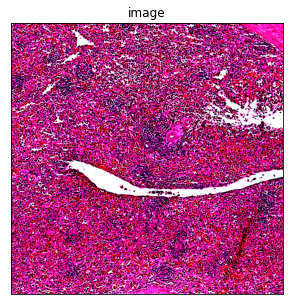

In [27]:
# normalization = lambda x: normalize_mean_std(normalize_0_255(x))    # <- best?
# normalization = lambda x: normalize_0_255(normalize_mean_std(x))
# normalization = lambda x: normalize_mean_std(x)
# normalization = lambda x: normalize_0_255(x) 
# normalization = lambda x: normalize_max(normalize_mean_std(normalize_0_255(x)))

# normalization = lambda x: normalize_max(x)
# normalization = lambda x: normalize_255_mean_std(x)
normalization = lambda x: normalize_255_mean_std_v2(x)


test_dataset = HuBMAP_Dataset(df_sample, normalization)
image, shape, _, empty, data_source, organ_type = test_dataset[0]

print(f'original image shape: \t\t{shape}')
print(f'image is not empty: \t\t{empty}')
print(f'tiled image shape: \t\t{image.shape}')
print(f'image data source: \t\t{data_source}')
print(f'image oragan type: \t\t{organ_type}')

if cfg.tiles:
    # merging the tiled mask
    merged_image = fold(image, out_size=cfg.img_size, size=cfg.tile_size, step=cfg.stride)
    print(f'reconstructed image shape: \t{merged_image.shape}')
    print()
    print(image.min(), image.max())
    print()

    plot_tiled_image(image, [5, 5])

if cfg.tiles:
    visualize(
        [5, 5],
        recon_img=np.transpose(merged_image[0, ...], (1, 2, 0))
    )
else:
    visualize(
        [5, 5],
        image=np.transpose(image, (1, 2, 0)),
    )

In [28]:
test_dataloader = DataLoader(test_dataset, batch_size=1, 
                             num_workers=2, shuffle=False, pin_memory=True, drop_last=False)

# image, image_shape, image_id  = next(iter(test_dataloader))

# if cfg.tiles: 
#     bs, n_tiles, c, h, w = image.size()
#     image = image.contiguous().view(-1, c, h, w)
            
# print(image.shape, image_shape[0].cpu().detach().numpy()[0], image_shape[1].cpu().detach().numpy()[0])

In [29]:
import scipy.ndimage as ndi
import skimage.morphology as morph
from skimage.filters import threshold_otsu

def clean_mask(mask, kernel=(3, 3)):
    structure = np.ones(kernel)
    mask = ndi.binary_fill_holes(mask, structure=structure)
    
    return mask

In [30]:
def pred_single_mask(input, model, thresh=0.5):
    pred = None 
    with torch.no_grad():
        pred = model(input)
        pred = (nn.Sigmoid()(pred)).double()    # fixed double thr problem

    return pred


def pred_mask(input, models, m_thresh=0.5):
    """
    predicting mask of each model (no tta)
    
    :input  : imput tensor of shape (b, c, h, w)
    :models : input list of loaded models
    :thresh : threshold used to binarize predicted prob map
    ---------
    :return : weighted mean of all masks
    """
    preds = []

    for model in models:
        with torch.no_grad():
            pred = pred_single_mask(input, model, thresh)
            preds.append(pred)

    preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()
    
    if cfg.tiles:
        preds = fold(preds, out_size=cfg.img_size, size=cfg.tile_size, step=cfg.stride)
    
    preds = preds.numpy()
    preds = (preds > m_thresh).astype(np.uint8)  # main fix with np.uint8

    return preds


def pred_mask_tta(input, models, thresh_factor=2.5):
    """
    predicting mask with tta of each model
    
    :tta    : flips = [[2], [3], [2, 3]]
    :input  : imput tensor of shape (b, c, h, w)
    :models : input list of loaded models
    :thresh : threshold used to binarize predicted prob map
    ---------
    :return : weighted mean of all masks
    """
    preds = []
    weights = []

    for model in models:
        with torch.no_grad():
            
            model_weight = model['weight']
            model = model['model']
            
            # sample prediction -- added v1.2
            pred = model(input)
            pred = (nn.Sigmoid()(pred)).double()    # fixed double thr problem

            pred *= model_weight
            preds.append(pred)
            weights.append(model_weight)
            
            # tta
            flips = [[2], [3], [2, 3]]
            for d in flips:
                t_image = torch.flip(input, dims=d)
                
                pred = model(t_image)
                pred = (nn.Sigmoid()(pred)).double()    # fixed double thr problem

                pred = torch.flip(pred, dims=d)

                pred *= model_weight
                preds.append(pred)
                weights.append(model_weight)

    # mask avareging
#     preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()
    
    # mask weighted avareging
    preds = torch.sum(torch.stack(preds, dim=0), dim=0) / np.sum(weights)
    preds = preds.cpu().detach()
    
    print(preds.shape)
    
    if cfg.tiles:
        preds = fold(preds, out_size=cfg.img_size, size=cfg.tile_size, step=cfg.stride)
        
    preds = preds.numpy()
    adaptive_thresh = np.mean(preds[preds > 0.02]) / thresh_factor
    preds = (preds > adaptive_thresh).astype(np.uint8)  # main fix with np.uint8

    return preds

  0%|          | 0/1 [00:00<?, ?it/s]

using thresh_factor: 1.75
using all models
torch.Size([1, 1, 612, 612])


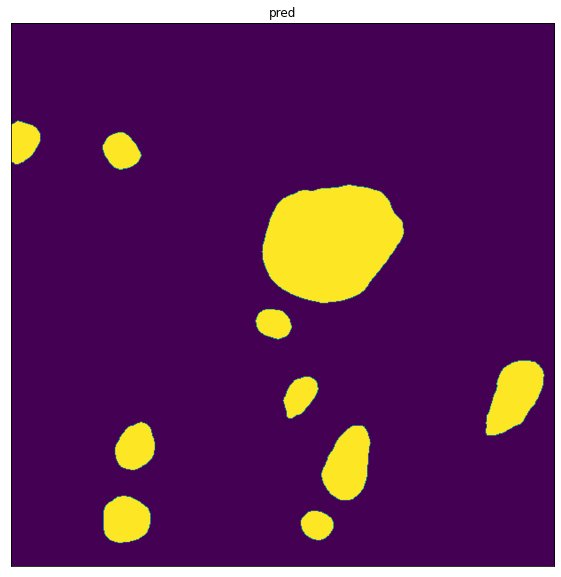

100%|██████████| 1/1 [00:18<00:00, 18.01s/it]


In [31]:
names, preds = [], []

for i in tqdm(range(len(test_dataset))):
    # get image
    image, image_shape, image_id, not_empty, data_source, organ_type = test_dataset[i]
    # add batch dimention
    image = image.view(1, *image.shape)  # [C, H, W] -> [B, C, H, W]
    image = image.to(cfg.device, dtype=torch.float)

    # handle empty images
#     if not not_empty or organ_type != 'spleen':   # include only spleen
#     if not not_empty or data_source != 'Hubmap':  # + include Hubmap
#     if not not_empty or data_source != 'HPA':     # + include HPA

#     if organ_type != 'lung':                        # predict on lung only
#         rle = ''
#         names.append(image_id)
#         preds.append(rle)
#         continue
    
    
    # get prediction
    thr_f = cfg.organ_mean_thresh_f[data_source][organ_type]
    print(f'using thresh_factor: {thr_f}')
    
    if organ_type == 'lung':
        print(f'using lung models')
    
        # predict
        if cfg.tta:
            pred = pred_mask_tta(image, lung_models, thresh_factor=thr_f)
        else:
            pred = pred_mask(image, lung_models, thresh_factor=thr_f)
            
        if np.all(pred == 0):
            for ii in range(5):
                thr_f -= 0.2
                # predict
                if cfg.tta:
                    pred = pred_mask_tta(image, lung_models, thresh_factor=thr_f)
                else:
                    pred = pred_mask(image, lung_models, thresh_factor=thr_f)
            
    else:
        print(f'using all models')

        # predict
        if cfg.tta:
            pred = pred_mask_tta(image, all_models, thresh_factor=thr_f)
        else:
            pred = pred_mask(image, all_models, thresh_factor=thr_f)
            
        if np.all(pred == 0):
            for ii in range(5):
                thr_f -= 0.2
                # predict
                if cfg.tta:
                    pred = pred_mask_tta(image, all_models, thresh_factor=thr_f)
                else:
                    pred = pred_mask(image, all_models, thresh_factor=thr_f)
            
            
    # resize back
    pred = cv2.resize(pred.squeeze(), image_shape)
    
    # fill the mask
#     pred = clean_mask(pred, kernel=(3, 3))

    visualize(
        [10, 10],
        pred=pred,
    )
    
    rle = rle_encode(pred)
    names.append(image_id)
    preds.append(rle)
    
    gc.collect()
    torch.cuda.empty_cache()

In [32]:
df = pd.DataFrame({'id': names, 'rle': preds})
df.to_csv('submission.csv', index=False)

In [33]:
df

,id,rle
0,10078,381 142 2404 142 4427 142 6450 142 8473 142 10...


In [34]:
# https://stackoverflow.com/questions/62995726/pytorch-sliding-window-with-unfold-fold


# v2.0:
# - added BGR->RGB
# - fixed double thr problem 
# - norm_255_mean_std

# v2.1
# - added sample tta

# v2.2
# - upernet-swin 
# - larger pred size 224 -> 512 (tiles - 1024x512x2) - 0.63
# v2.2.1
# - added INTER_AREA to image rescaling before unfold + INTER_CUBIC for final resize to original shape

# v3.1.3
# - added INTER_LANCZOS4 to image rescaling for final resize to original shape

# - infer size 768 -> lb 0.76
# - infer size 736 -> lb 0.76+
# - infer size 704 -> lb 0.77-
# - infer size 672 -> lb 0.77+
# - infer size 640 -> 

# - infer size 768 + [normalize image shape by its pixel size] -> 